# Classifying Tissue Patches from IDC Slides with TIAToolbox

<a href="https://colab.research.google.com/github/fedorov/idc-tiatoolbox/blob/main/notebooks/04_patch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview

TIAToolbox's `PatchPredictor` can classify tissue patches using pretrained deep learning models. In this notebook, we use the **ResNet18-Kather100K** model to classify tissue in a colorectal cancer slide from IDC into 9 tissue types:

1. Adipose
2. Background
3. Debris
4. Lymphocytes
5. Mucus
6. Smooth muscle
7. Normal colon mucosa
8. Cancer-associated stroma
9. Colorectal adenocarcinoma epithelium

**GPU recommended** for faster inference (but works on CPU too).

## Installation

Run the cell below to install dependencies. **On Colab, the runtime will automatically restart** after installation to pick up the updated numpy version. After the restart, continue from the imports cell below.

In [ ]:
%%capture
%pip install "tiatoolbox==1.6.0" idc-index openslide-bin "numcodecs<0.16"

# Restart runtime to pick up updated numpy (required on Colab)
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

In [ ]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch
from pathlib import Path

from idc_index import IDCClient
from tiatoolbox.wsicore.wsireader import WSIReader
from tiatoolbox.models.engine.patch_predictor import PatchPredictor

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    try:
        torch.zeros(1, device="cuda")
    except RuntimeError:
        print("CUDA available but not functional — falling back to CPU")
        device = "cpu"
print(f"Using device: {device}")
if device == "cpu":
    print("Note: GPU is recommended for faster inference.")
    print("In Colab: Runtime > Change runtime type > T4 GPU")

  check_for_updates()



Using device: cuda


## Reproducibility Information

Capture execution timestamp and environment details for reproducibility.

In [ ]:
import datetime, os, platform, subprocess, sys
from importlib.metadata import version, PackageNotFoundError

print(f"Executed: {datetime.datetime.now(datetime.timezone.utc).strftime('%Y-%m-%d %H:%M:%S UTC')}")
print(f"Platform: {platform.platform()}")
print(f"Python:   {sys.version}")

# Detect Colab environment and runtime version
try:
    import google.colab  # noqa: F401
    colab_env = "Google Colab"
    # Try to get the Colab runtime version (e.g., "2026.01")
    colab_release = os.environ.get("COLAB_RELEASE_TAG")
    if colab_release:
        colab_env += f" (runtime {colab_release})"
    else:
        # Fall back to google-colab package version as a proxy
        try:
            colab_env += f" (google-colab {version('google-colab')})"
        except PackageNotFoundError:
            pass
    print(f"Runtime:  {colab_env}")
except ImportError:
    print("Runtime:  Local")

print("\nKey package versions:")
for pkg in ["tiatoolbox", "idc-index", "numpy", "matplotlib",
            "openslide-bin", "torch", "highdicom", "wsidicom", "shapely"]:
    try:
        print(f"  {pkg}: {version(pkg)}")
    except PackageNotFoundError:
        pass

try:
    import psutil
    ram = psutil.virtual_memory()
    print(f"\nRAM: {ram.total / (1024**3):.1f} GB total, {ram.available / (1024**3):.1f} GB available")
except ImportError:
    pass

try:
    result = subprocess.run(
        ["nvidia-smi", "--query-gpu=name,memory.total,driver_version", "--format=csv,noheader"],
        capture_output=True, text=True, timeout=5,
    )
    if result.returncode == 0:
        print(f"GPU:  {result.stdout.strip()}")
    else:
        print("GPU:  Not available")
except (FileNotFoundError, subprocess.TimeoutExpired):
    print("GPU:  Not available")

Executed: 2026-02-18 19:25:32 UTC
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Python:   3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Runtime:  Google Colab (runtime release-colab-external_20260213-060047_RC00)

Key package versions:
  tiatoolbox: 1.6.0
  idc-index: 0.11.9
  numpy: 1.26.4
  matplotlib: 3.9.3
  openslide-bin: 4.0.0.11
  torch: 2.5.1
  wsidicom: 0.22.0
  shapely: 2.0.6

RAM: 12.7 GB total, 10.3 GB available
GPU:  Tesla T4, 15360 MiB, 580.82.07


## 1. Select and Download a Colorectal Cancer Slide

The Kather100K model was trained on colorectal cancer tissue, so we'll use a slide from the `tcga_coad` (TCGA Colon Adenocarcinoma) collection for best results.

In [ ]:
idc_client = IDCClient()
idc_client.fetch_index("sm_index")

candidates = idc_client.sql_query("""
    SELECT
        i.SeriesInstanceUID,
        i.PatientID,
        i.collection_id,
        ROUND(i.series_size_MB, 1) as size_mb,
        s.ObjectiveLensPower,
        s.max_TotalPixelMatrixColumns as width,
        s.max_TotalPixelMatrixRows as height,
        s.min_PixelSpacing_2sf as pixel_spacing_mm
    FROM sm_index s
    JOIN index i ON s.SeriesInstanceUID = i.SeriesInstanceUID
    WHERE i.collection_id = 'tcga_coad'
        AND s.ObjectiveLensPower >= 20
    ORDER BY i.series_size_MB ASC
    LIMIT 5
""")

selected = candidates.iloc[0]
series_uid = selected['SeriesInstanceUID']
print(f"Selected: {selected['PatientID']}, {selected['size_mb']} MB")
print(f"  Dimensions: {selected['width']}x{selected['height']} @ {selected['ObjectiveLensPower']}x")

Selected: TCGA-D5-6922, 11.3 MB
  Dimensions: 23981x19111 @ 40x


In [ ]:
download_dir = './slides'
os.makedirs(download_dir, exist_ok=True)

idc_client.download_from_selection(
    downloadDir=download_dir,
    seriesInstanceUID=[series_uid],
    dirTemplate='%SeriesInstanceUID'
)

slide_path = os.path.join(download_dir, series_uid)
reader = WSIReader.open(slide_path)

# DICOMWSIReader may not populate objective_power or mpp
info = reader.info
if info.objective_power is None:
    info.objective_power = float(selected['ObjectiveLensPower'])
if info.mpp is None:
    pixel_spacing_um = float(selected['pixel_spacing_mm']) * 1000
    info.mpp = np.array([pixel_spacing_um, pixel_spacing_um])

print(f"Opened: {type(reader).__name__}, dimensions: {info.slide_dimensions}")

Opened: DICOMWSIReader, dimensions: (23981, 19111)


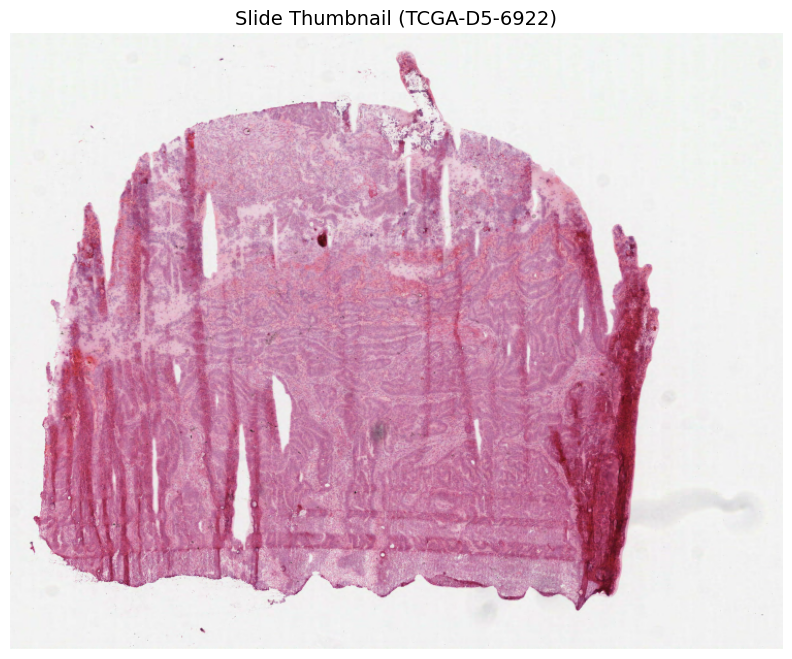

In [ ]:
# Show slide thumbnail
thumbnail = reader.slide_thumbnail(resolution=1.25, units="power")
plt.figure(figsize=(10, 8))
plt.imshow(thumbnail)
plt.title(f"Slide Thumbnail ({selected['PatientID']})", fontsize=14)
plt.axis('off')
plt.show()

## 2. Run Patch Classification with PatchPredictor

TIAToolbox's `PatchPredictor` supports three modes:
- **`patch`**: Classify individual images/patches
- **`tile`**: Classify a larger image tile
- **`wsi`**: Classify an entire whole slide image with automatic patch extraction

We'll use **WSI mode** which automatically extracts patches from tissue regions and classifies them.

### About the Kather100K Model

The `resnet18-kather100k` model is a ResNet-18 architecture trained on the [NCT-CRC-HE-100K dataset](https://zenodo.org/record/1214456) for 9-class tissue type classification in colorectal cancer histology.

In [ ]:
# Initialize PatchPredictor with pretrained model
predictor = PatchPredictor(
    pretrained_model="resnet18-kather100k",
    batch_size=64,
)

# Kather100K class labels, index 0-8, matching model output order.
# Source: KatherPatchDataset in tiatoolbox v1.6.0 (commit e14a4fc),
# file tiatoolbox/models/dataset/info.py, lines 88-96.
# Training directories are enumerated in this order and mapped to
# consecutive integer labels (lines 120-128 in the same file).
# PatchPredictor does not expose these labels as an attribute.
class_names = ["BACK", "NORM", "DEB", "TUM", "ADI", "MUC", "MUS", "STR", "LYM"]

print(f"Model: resnet18-kather100k")
print(f"Classes: {class_names}")

  saved_state_dict = torch.load(pretrained_weights, map_location="cpu")



Model: resnet18-kather100k
Classes: ['BACK', 'NORM', 'DEB', 'TUM', 'ADI', 'MUC', 'MUS', 'STR', 'LYM']


In [ ]:
# Run prediction in WSI mode
# This will automatically extract patches from tissue regions and classify them

# Workarounds for DICOM WSI from IDC:
# 1. tiatoolbox's WSIPatchDataset rejects directories (DICOM WSIs are dirs)
# 2. DICOMWSIReader may not populate objective_power/mpp from metadata,
#    but PatchPredictor creates its own WSIReader internally so the
#    metadata fixes from the earlier cell don't carry over.
import pathlib
from tiatoolbox.wsicore.wsireader import WSIReader

# Workaround 1: Allow directories to pass Path.is_file() check
_real_is_file = pathlib.Path.is_file
pathlib.Path.is_file = lambda self: _real_is_file(self) or self.is_dir()

# Workaround 2: Inject missing metadata into any newly opened WSIReader
_orig_open = WSIReader.open

def _patched_open(input_img, mpp=None, power=None, **kwargs):
    rdr = _orig_open(input_img, mpp=mpp, power=power, **kwargs)
    if rdr.info.objective_power is None:
        rdr.info.objective_power = float(selected['ObjectiveLensPower'])
    if rdr.info.mpp is None:
        px_um = float(selected['pixel_spacing_mm']) * 1000
        rdr.info.mpp = np.array([px_um, px_um])
    return rdr

WSIReader.open = staticmethod(_patched_open)

try:
    output = predictor.predict(
        imgs=[Path(slide_path)],
        mode="wsi",
        save_dir="./patch_pred_results/",
        patch_input_shape=(224, 224),
        stride_shape=(224, 224),
        resolution=0.5,
        units="mpp",
        device=device,
    )
finally:
    pathlib.Path.is_file = _real_is_file
    WSIReader.open = _orig_open

print(f"Prediction complete!")
print(f"Number of patches classified: {len(output[0]['predictions'])}")

100%|###########################################| 21/21 [00:33<00:00,  1.61s/it]

Prediction complete!
Number of patches classified: 1343


## 3. Visualize Classification Results

Let's create a tissue classification heatmap showing what type of tissue is present at each location.

In [ ]:
# Extract predictions and coordinates
predictions = output[0]['predictions']
coordinates = output[0]['coordinates']

# class_names is defined in the model initialization cell above

# Kather100K class colors for visualization
class_colors = {
    'ADI': [0.9, 0.8, 0.2],   # Adipose - yellow
    'BACK': [0.9, 0.9, 0.9],  # Background - light gray
    'DEB': [0.5, 0.3, 0.1],   # Debris - brown
    'LYM': [0.2, 0.6, 0.9],   # Lymphocytes - blue
    'MUC': [0.8, 0.4, 0.8],   # Mucus - purple
    'MUS': [0.9, 0.5, 0.3],   # Smooth muscle - orange
    'NORM': [0.3, 0.8, 0.3],  # Normal mucosa - green
    'STR': [0.6, 0.6, 0.6],   # Stroma - gray
    'TUM': [0.9, 0.2, 0.2],   # Tumor - red
}

print(f"Class names: {class_names}")
print(f"\nPrediction distribution:")
unique, counts = np.unique(predictions, return_counts=True)
for cls_idx, count in zip(unique, counts):
    name = class_names[cls_idx]
    pct = count / len(predictions) * 100
    print(f"  {name}: {count} patches ({pct:.1f}%)")

Class names: ['BACK', 'NORM', 'DEB', 'TUM', 'ADI', 'MUC', 'MUS', 'STR', 'LYM']

Prediction distribution:
  BACK: 44 patches (3.3%)
  NORM: 1 patches (0.1%)
  DEB: 951 patches (70.8%)
  ADI: 1 patches (0.1%)
  MUC: 280 patches (20.8%)
  MUS: 9 patches (0.7%)
  STR: 57 patches (4.2%)


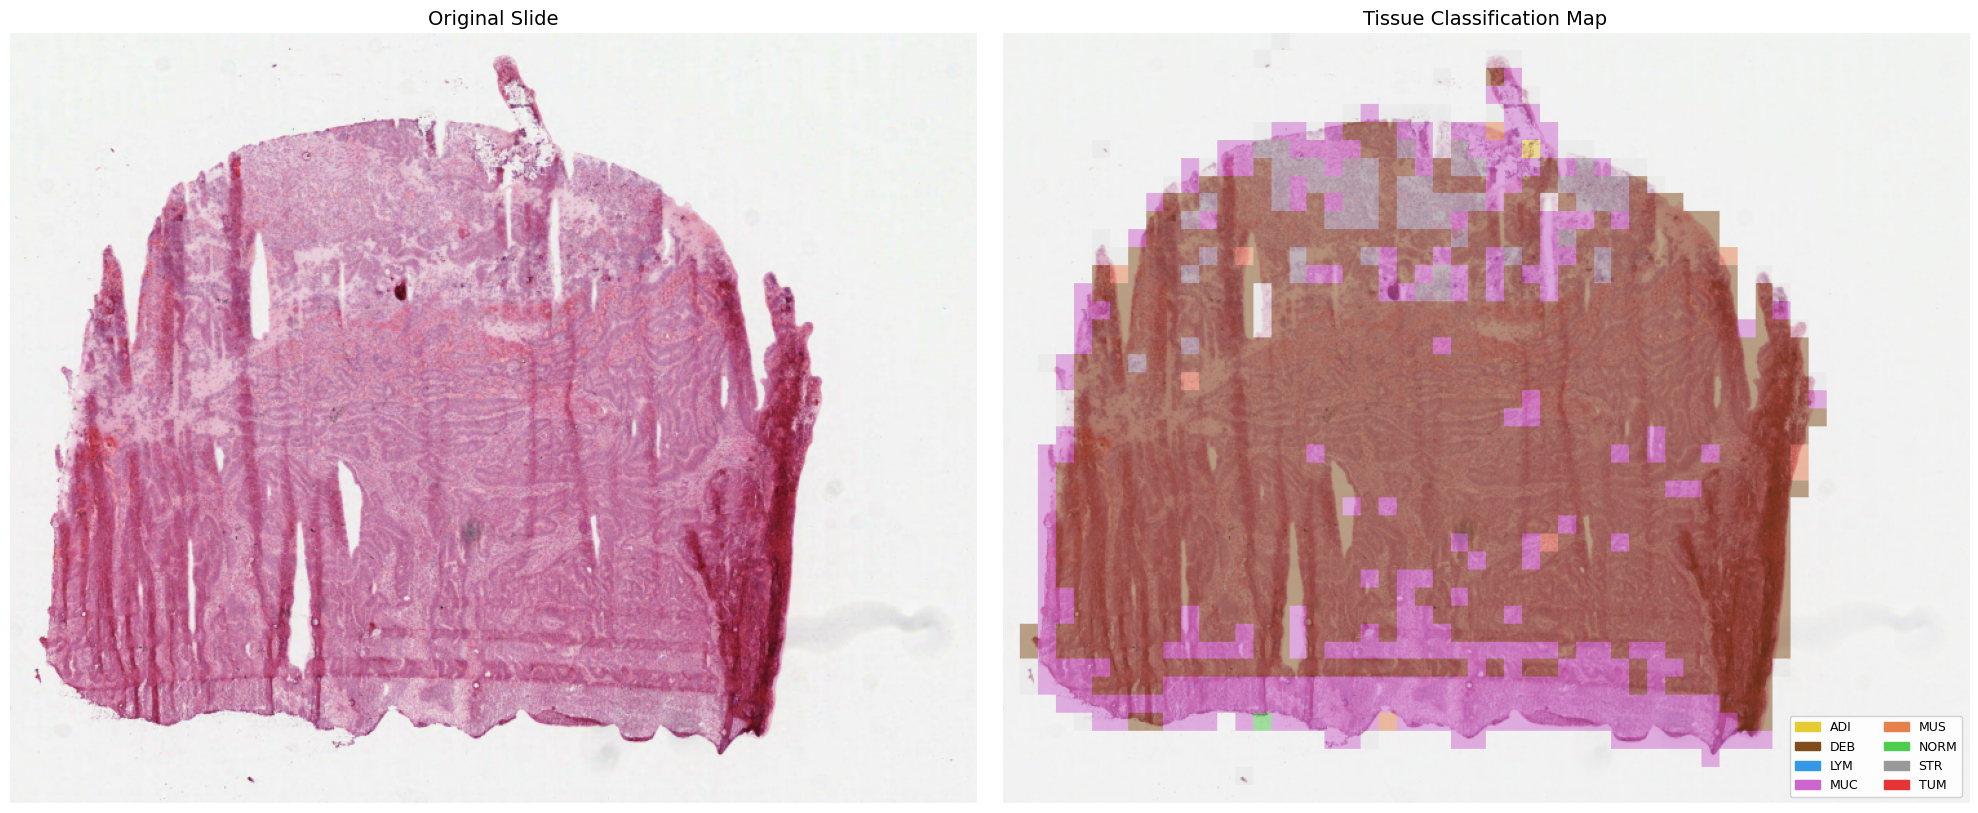

In [ ]:
# Create a prediction overlay on the thumbnail
# Coordinates from PatchPredictor are in the extraction resolution space
# (coord_space="resolution"), not baseline. Use slide dimensions at 0.5 mpp.
wsi_shape = reader.slide_dimensions(resolution=0.5, units="mpp")
slide_w, slide_h = wsi_shape
thumb_h, thumb_w = thumbnail.shape[:2]

# Create an overlay image
overlay = np.ones((thumb_h, thumb_w, 3), dtype=np.float32) * 0.95

for pred, coord in zip(predictions, coordinates):
    # coord is (x_start, y_start, x_end, y_end) in extraction resolution coords
    x1 = int(coord[0] * thumb_w / slide_w)
    y1 = int(coord[1] * thumb_h / slide_h)
    x2 = int(coord[2] * thumb_w / slide_w)
    y2 = int(coord[3] * thumb_h / slide_h)

    class_name = class_names[pred]
    color = class_colors.get(class_name, [0.5, 0.5, 0.5])
    overlay[y1:y2, x1:x2] = color

# Blend with thumbnail
alpha = 0.5
blended = (alpha * overlay + (1 - alpha) * thumbnail / 255.0)
blended = np.clip(blended, 0, 1)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].imshow(thumbnail)
axes[0].set_title("Original Slide", fontsize=14)
axes[0].axis('off')

axes[1].imshow(blended)
axes[1].set_title("Tissue Classification Map", fontsize=14)
axes[1].axis('off')

# Add legend
legend_patches = [
    mpatches.Patch(color=color, label=name)
    for name, color in class_colors.items()
    if name != 'BACK'
]
axes[1].legend(handles=legend_patches, loc='lower right', fontsize=9,
               framealpha=0.9, ncol=2)

plt.tight_layout()
plt.show()

## 4. Examine High-Confidence Predictions

Let's look at some example patches for the most common tissue types to verify the classifications look reasonable.

Showing top 4 tissue types: ['DEB', 'MUC', 'STR', 'MUS']


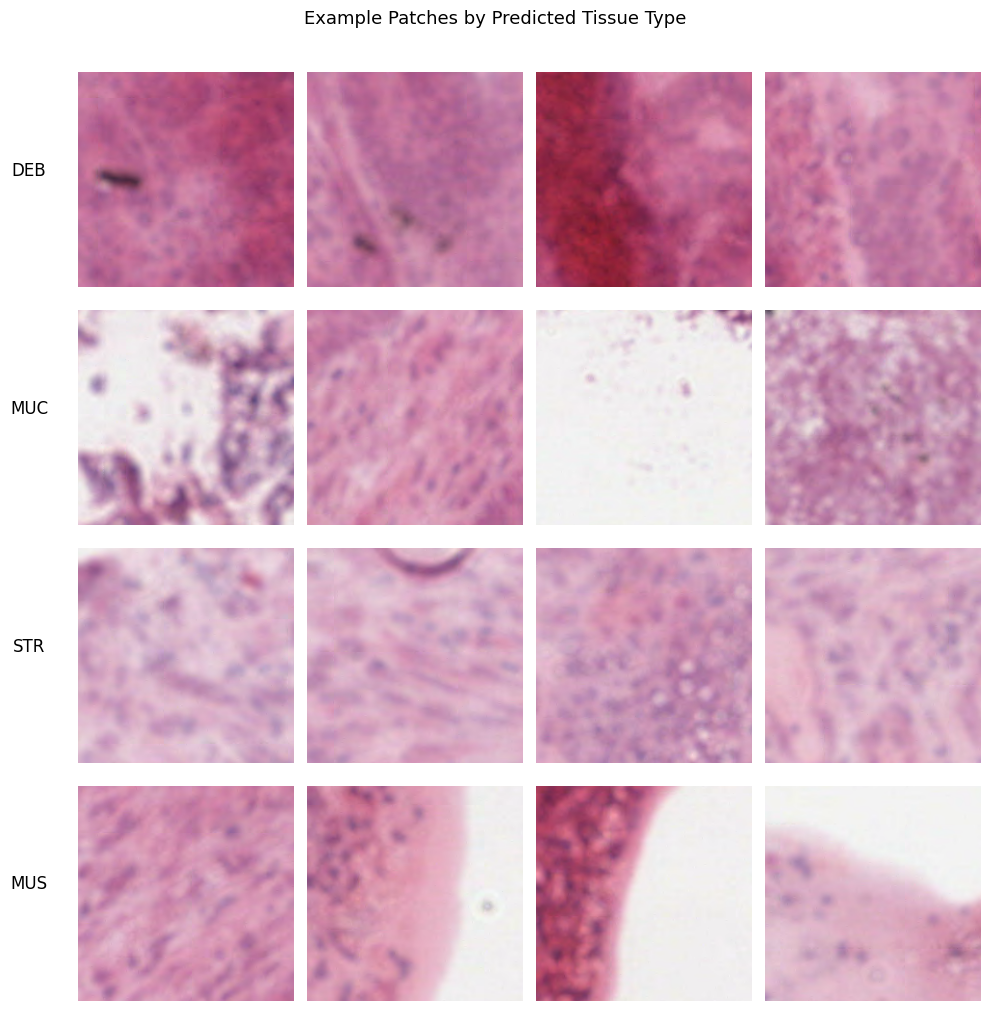

In [ ]:
# Show example patches for the most common tissue types (excluding background)
n_examples = 4
n_types = 4

# Dynamically select the most frequent non-background classes
unique, counts = np.unique(predictions, return_counts=True)
freq = sorted(zip(unique, counts), key=lambda x: -x[1])
types_to_show = [
    class_names[idx] for idx, _ in freq
    if class_names[idx] != 'BACK'
][:n_types]

print(f"Showing top {len(types_to_show)} tissue types: {types_to_show}")

fig, axes = plt.subplots(len(types_to_show), n_examples, figsize=(2.5 * n_examples, 2.5 * len(types_to_show)))

for row, tissue_type in enumerate(types_to_show):
    type_idx = class_names.index(tissue_type)
    matching = [(i, c) for i, (p, c) in enumerate(zip(predictions, coordinates)) if p == type_idx]

    # Sample up to n_examples
    np.random.seed(42)
    if len(matching) > n_examples:
        sample_indices = np.random.choice(len(matching), n_examples, replace=False)
        matching = [matching[i] for i in sample_indices]

    for col in range(n_examples):
        ax = axes[row][col]
        if col < len(matching):
            _, coord = matching[col]
            # PatchPredictor returns coordinates in the extraction resolution
            # space (0.5 mpp), not baseline. This is because WSIPatchDataset
            # generates its patch grid at the requested resolution
            # (classification.py line 298) and reads patches with
            # coord_space="resolution" (line 356).
            # We must use the same resolution and coord_space when reading
            # back individual patches, otherwise the bounds will be wrong
            # (shifted/scaled) relative to the actual tissue locations.
            patch = reader.read_bounds(
                bounds=coord,
                resolution=0.5,
                units="mpp",
                coord_space="resolution",
            )
            ax.imshow(patch)
        # Hide ticks and spines but keep ylabel visible
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        if col == 0:
            ax.set_ylabel(tissue_type, fontsize=12, rotation=0, labelpad=35)

plt.suptitle("Example Patches by Predicted Tissue Type", fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

## 5. View in SLIM Viewer

Compare the computational predictions with the actual slide using IDC's interactive viewer.

In [ ]:
viewer_url = idc_client.get_viewer_URL(seriesInstanceUID=series_uid)
print(f"View this slide in SLIM viewer:")
print(viewer_url)

View this slide in SLIM viewer:
https://viewer.imaging.datacommons.cancer.gov/slim/studies/2.25.126166883631657808304946665442870446050/series/1.3.6.1.4.1.5962.99.1.3202112048.1645731704.1639584684592.2.0


## Summary

In this notebook, we learned how to:

- Use `PatchPredictor` with the pretrained `resnet18-kather100k` model for 9-class tissue classification
- Run inference in **WSI mode**, which automatically handles patch extraction from tissue regions
- Visualize predictions as a color-coded tissue classification map overlaid on the slide
- Inspect individual patches to verify classification quality

**Available pretrained models** for patch classification include ResNet, DenseNet, MobileNet variants trained on:
- **Kather100K**: 9-class colorectal tissue classification
- **PCam**: Binary cancer detection in lymph node metastases

**Next:** [Notebook 05](05_semantic_segmentation.ipynb) demonstrates pixel-level tissue region segmentation.

## Acknowledgments

- **IDC:** Fedorov, A., et al. "National Cancer Institute Imaging Data Commons: Toward Transparency, Reproducibility, and Scalability in Imaging Artificial Intelligence." *RadioGraphics* 43.12 (2023). https://doi.org/10.1148/rg.230180
- **TIAToolbox:** Pocock, J., et al. "TIAToolbox as an end-to-end library for advanced tissue image analytics." *Communications Medicine* 2, 120 (2022). https://doi.org/10.1038/s43856-022-00186-5
- **Kather100K:** Kather, J.N., et al. "Predicting survival from colorectal cancer histology slides using deep learning: A retrospective multicenter study." *PLOS Medicine* 16.1 (2019). https://doi.org/10.1371/journal.pmed.1002730